# Movie Recommender

**Goal:** Build a movie recommendation system.

**Summary:** The primary purpose of this notebook is to build a model that 
makes movie recommendations based on ratings supplied by a user. We build 
our recommendation system using *matrix factorization*, a collaborative 
filtering algorithm. 

The main idea of the matrix factorization algorithm is to decompose the 
user-movie ratings (sparse) matrix $R$ into a product $UV$, where $U$ and 
$V$ are low-rank matrices. Optimal $U$ and $V$ are found by minimizing the 
error arising from the approximation $R \approx UV$. This is a difficult 
optimization problem, since the objective function is non-convex. Instead, 
we solve a convex optimization problem by alternately treating $U$ and $V$ 
as constants during gradient descent, an approach known as 
*Alternating Least Squares (ALS)*. 

We summarize below our findings and the actions taken to achieve the stated 
goal.

1) **Explore the data:** We load the *ratings* and *movies* datasets
into a Spark DataFrame. We visualize the ratings distribution, and take
a look at some statistics for the ratings count per user and per movie.
We take a look at the most-rated movies and the highest-rated movies.


2) **Split the data into training and test sets:**  We split the *ratings* 
dataset into training (80%) and test (20%) sets.


3) **Select a model:** We use a cross-validator to determine optimal
hyperparameters. The optimal choice for the rank and the regularization
parameter turn out to be 10 and 0.1, respectively.


4) **Evaluate the model:** We evaluate our best model by computing its
Root Mean Square Error (RMSE) on the test set, and comparing it with
the corresponding error for the baseline model. Our best model improves 
the baseline model by approximately 15%.


5) **Make recommendations:** Suppose that we want to make recommendations
based on the ratings $y$ supplied by a new user. One approach is to append 
$y$ to the training set, retrain the model, and then make recommendations. 
However, with this approach, recommendations will not be available immediately. 
Instead, we use the following approach, which will enable to make immediate 
recommendations:

* Find an approximation $\theta$ of the user factor vector for 
the new user.

* Compute the product $\theta V$ to obtain predicted ratings for the new 
user, and then make recommendations.

In [1]:
# Load required packages and modules.
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from matplotlib.ticker import PercentFormatter
from warnings import simplefilter

# Suppress performance and data type warnings.
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set the backend of matplotlib to 'inline'.
%matplotlib inline

# Create plots using seaborn's default aesthetic arguments. 
sns.set()

# Make this notebook's output identical across runs.
np.random.seed(1)
SEED = 1

## 1. Explore the Dataset

In [2]:
# Path to the data.
DATA_DIR_PATH = pathlib.Path('/home/dn/notebooks/movie_recommender/data/ml-latest')
RATINGS_PATH = DATA_DIR_PATH.joinpath('ratings.csv')
MOVIES_PATH = DATA_DIR_PATH.joinpath('movies.csv')

# Path to the directory in which to save models.
SAVED_MODELS_DIR_PATH = pathlib.Path('/home/dn/notebooks/movie_recommender/saved_models')

Let's take a look at the first five lines of the *ratings.csv* file:

In [3]:
!head -n 5 {RATINGS_PATH}

Let's take a look at the first five lines of the *movies.csv* file:

In [4]:
!head -n 5 {MOVIES_PATH}

In [5]:
spark = (SparkSession
         .builder
         .appName('Movie Recommendation')
         .config('spark.driver.memory', '5g')
         .getOrCreate())

Let's create schemas for the *ratings.csv* and *movies.csv* files, before
reading them into a Spark DataFrame:

In [6]:
ratings_schema = StructType([
    StructField('userId', IntegerType()),
    StructField('movieId', IntegerType()),
    StructField('rating', DoubleType()),
    StructField('timestamp', IntegerType())
])
movies_schema = StructType([
    StructField('movieId', IntegerType()),
    StructField('title', StringType()),
    StructField('genre', StringType())
])

Read the *ratings* and *movies* data into a Spark DataFrame:

In [7]:
ratings_df = spark.read.csv(path=str(RATINGS_PATH), 
                            header=True, 
                            schema=ratings_schema)
              
movies_df = spark.read.csv(path=str(MOVIES_PATH), 
                           header=True, 
                           schema=movies_schema)

We don't need the **timestamp** column in the *ratings* DataFrame, so let's
drop it:

In [8]:
ratings_df = ratings_df.drop('timestamp')

What is the total number of ratings? What is the total number of movies?

In [9]:
n_ratings = ratings_df.count()
n_movies = movies_df.count()
print('Number of ratings:', n_ratings)
print('Number of movies:', n_movies)

Number of ratings: 27753444
Number of movies: 58098


Let's take a look at a few randomly chosen rows of the *ratings* dataset:

In [10]:
ratings_df.sample(fraction=10/n_ratings, seed=SEED).show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|  8450|   8340|   2.5|
| 16795|   1214|   5.0|
| 42656| 130508|   3.5|
| 50482|   1200|   4.5|
| 96682|   1214|   4.0|
|104515|   4363|   3.5|
|125062| 104879|   4.5|
|132956|   2420|   3.0|
|150824|   2686|   4.0|
|157809|   2718|   3.0|
|209488|   1079|   3.0|
+------+-------+------+



Let's take a look at a few randomly chosen rows of the *movies* dataset:

In [11]:
movies_df.sample(fraction=10/n_movies, seed=SEED).show(truncate=False)

+-------+-------------------------------------------+-----------------------+
|movieId|title                                      |genre                  |
+-------+-------------------------------------------+-----------------------+
|814    |Boy Called Hate, A (1995)                  |Drama                  |
|1284   |Big Sleep, The (1946)                      |Crime|Film-Noir|Mystery|
|102376 |Enter the Phoenix (Da lao ai mei li) (2004)|Action|Comedy          |
|138008 |New Year (2011)                            |(no genres listed)     |
|159658 |A Performance of Macbeth (1979)            |Drama                  |
|174711 |You Get Me (2017)                          |Drama|Romance|Thriller |
+-------+-------------------------------------------+-----------------------+



What is the total number of users? What is the total number of rated movies?

In [12]:
n_users = ratings_df.select('userId').distinct().count()
n_rated_movies = ratings_df.select('movieId').distinct().count()
print('Number of users:', n_users)
print('Number of rated movies:', n_rated_movies)

Number of users: 283228
Number of rated movies: 53889


What is the rating scale?

In [13]:
ratings_df.select('rating').distinct().orderBy('rating').show()

+------+
|rating|
+------+
|   0.5|
|   1.0|
|   1.5|
|   2.0|
|   2.5|
|   3.0|
|   3.5|
|   4.0|
|   4.5|
|   5.0|
+------+



Let's take a look at some statistics for the ratings:

In [14]:
(ratings_df
 .select('rating')
 .summary()
 .select('summary', F.round('rating', 2).alias('rating'))
 .show())

+-------+-----------+
|summary|     rating|
+-------+-----------+
|  count|2.7753444E7|
|   mean|       3.53|
| stddev|       1.07|
|    min|        0.5|
|    25%|        3.0|
|    50%|        3.5|
|    75%|        4.0|
|    max|        5.0|
+-------+-----------+



Let's visualize the distribution of ratings:

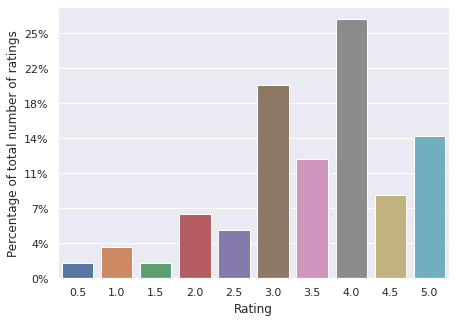

In [15]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(1, 1, 1)
pd_df = (ratings_df
         .select('rating')
         .groupBy('rating')
         .count()
         .orderBy('rating')).toPandas()

sns.barplot(x=pd_df['rating'], y=pd_df['count'], ax=ax)     
ax.set_title('')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of total number of ratings')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=n_ratings, decimals=0)) 

* Ratings range from 0.5 to 5.0, with increments of 0.5. 

* The median rating is 3.5.

* The most common rating is 4.0, accounting for approximately 27% of all
ratings.

Let's gather the ratings count and average for each user and each movie:

In [16]:
ratings_count_and_avg = {'Users': None, 'Movies': None}

ratings_count_and_avg['Users'] = (
    ratings_df
    .select('userId', 'rating')
    .groupBy('userId')
    .agg(F.count('rating').alias('num_of_ratings'), 
         F.avg('rating').alias('avg_rating'))
)

ratings_count_and_avg['Movies'] = (
    ratings_df
    .select('movieId', 'rating')
    .groupBy('movieId')
    .agg(F.count('rating').alias('num_of_ratings'), 
         F.avg('rating').alias('avg_rating'))
)

ratings_count_and_avg_pd = {}

for key in ratings_count_and_avg.keys():
    ratings_count_and_avg_pd[key] = ratings_count_and_avg[key].toPandas()

Let's take a look at some statistics for the ratings count:

In [17]:
# Round to zero decimal places in pandas. 
pd.options.display.float_format = '{:.0f}'.format

percentiles=[0.5, 0.85]
pd.merge(ratings_count_and_avg_pd['Users']['num_of_ratings']
         .describe(percentiles=percentiles), 
         ratings_count_and_avg_pd['Movies']['num_of_ratings']
         .describe(percentiles=percentiles),
         left_index=True,
         right_index=True,
         suffixes=('_per_user', '_per_movie'))

,num_of_ratings_per_user,num_of_ratings_per_movie
count,283228,53889
mean,98,515
std,213,2935
min,1,1
50%,30,7
85%,165,205
max,23715,97999


Next, we wish to take a look at the histograms of the ratings count.
To make the histograms effective, we will handle outliers by manually 
choose bin edges and clip points:

In [18]:
bin_edges_and_clips = {
    'Users': {'bin_edges': np.arange(0, 401, 8), 'a_max': 400},
    'Movies': {'bin_edges': np.arange(0, 201, 4), 'a_max': 200}
}

Now that bin edges and clip points have been chosen, let's plot the 
histograms:

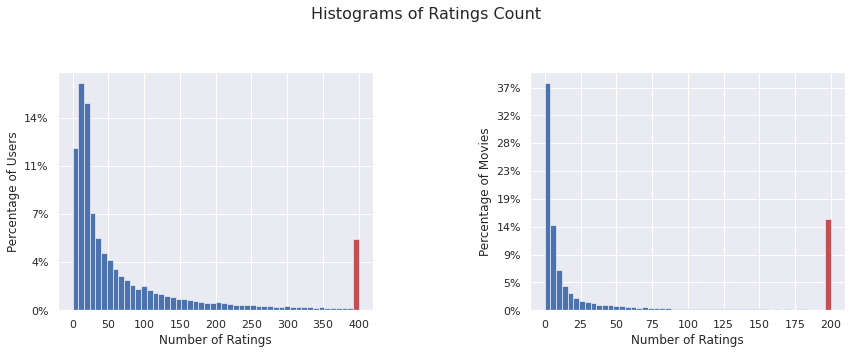

In [19]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle('Histograms of Ratings Count', fontsize=16)

for counter, key in enumerate(ratings_count_and_avg_pd.keys(), 1):
    ax = fig.add_subplot(1, 2, counter)
    pd_df = ratings_count_and_avg_pd[key]['num_of_ratings']
    x = np.clip(pd_df, a_min=None, a_max=bin_edges_and_clips[key]['a_max']) 
    sns.histplot(bins=bin_edges_and_clips[key]['bin_edges'], 
                 x=x, stat='count', alpha=1, ax=ax)
    ax.patches[-1].set_facecolor('r')
    fig.canvas.draw() 
    ax.set_title('')  
    ax.set_xlabel('Number of Ratings')
    ax.set_ylabel(f'Percentage of {key}')  
    xmax = len(pd_df)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=xmax, decimals=0))
    
fig.tight_layout()
fig.subplots_adjust(top=0.8, wspace=0.5, hspace=0.4)

* The red-colored bars include all values greater than or equal to the 
left edge of the bar.

* The median number of ratings per user is 30, with minimum 1, and
maximum 23,715.

* The median number of ratings per movies is 7, with minimum 1, and
maximum 97,999.

* 85% of the users gave 165 or fewer ratings each.

* 85% of the movies received 205 or fewer ratings each.

What are the top fifteen most-rated movies?

In [20]:
# Convert the 'movies' Spark DataFrame into a Pandas DataFrame.
movies_pd = movies_df.toPandas()

# Round to two decimal places in pandas. 
pd.options.display.float_format = '{:.2f}'.format

(ratings_count_and_avg_pd['Movies']
 .sort_values(by=['num_of_ratings'], ascending=False)
 .head(15)
 .merge(movies_pd[['movieId', 'title']], on='movieId', how='left'))

,movieId,num_of_ratings,avg_rating,title
0,318,97999,4.42,"Shawshank Redemption, The (1994)"
1,356,97040,4.06,Forrest Gump (1994)
2,296,92406,4.17,Pulp Fiction (1994)
3,593,87899,4.15,"Silence of the Lambs, The (1991)"
4,2571,84545,4.15,"Matrix, The (1999)"
5,260,81815,4.12,Star Wars: Episode IV - A New Hope (1977)
6,480,76451,3.67,Jurassic Park (1993)
7,527,71516,4.26,Schindler's List (1993)
8,110,68803,4.01,Braveheart (1995)
9,1,68469,3.89,Toy Story (1995)


What are the top fifteen highest-rated movies that received at least 500 ratings?

In [21]:
mask = ratings_count_and_avg_pd['Movies']['num_of_ratings'] >= 500
(ratings_count_and_avg_pd['Movies'][mask] 
 .sort_values(by=['avg_rating'], ascending=False)
 .head(15)
 .merge(movies_pd[['movieId', 'title']], on='movieId', how='left'))

,movieId,num_of_ratings,avg_rating,title
0,171011,853,4.49,Planet Earth II (2016)
1,159817,1384,4.46,Planet Earth (2006)
2,318,97999,4.42,"Shawshank Redemption, The (1994)"
3,170705,984,4.40,Band of Brothers (2001)
4,174053,1074,4.35,Black Mirror: White Christmas (2014)
5,858,60904,4.33,"Godfather, The (1972)"
6,50,62180,4.29,"Usual Suspects, The (1995)"
7,1221,38875,4.26,"Godfather: Part II, The (1974)"
8,527,71516,4.26,Schindler's List (1993)
9,2019,14578,4.25,Seven Samurai (Shichinin no samurai) (1954)


What are the top fifteen lowest-rated movies that received at least 500 ratings?

In [22]:
mask = ratings_count_and_avg_pd['Movies']['num_of_ratings'] >= 500
(ratings_count_and_avg_pd['Movies'][mask] 
 .sort_values(by=['avg_rating'], ascending=True)
 .head(15)
 .merge(movies_pd[['movieId', 'title']], on='movieId', how='left'))

,movieId,num_of_ratings,avg_rating,title
0,4775,741,1.14,Glitter (2001)
1,6587,810,1.21,Gigli (2003)
2,31698,680,1.24,Son of the Mask (2005)
3,61348,593,1.27,Disaster Movie (2008)
4,6872,521,1.36,"House of the Dead, The (2003)"
5,1495,770,1.42,Turbo: A Power Rangers Movie (1997)
6,50798,1281,1.47,Epic Movie (2007)
7,5672,564,1.47,Pokemon 4 Ever (a.k.a. Pokémon 4: The Movie) (...
8,31424,564,1.51,Alone in the Dark (2005)
9,1739,668,1.59,3 Ninjas: High Noon On Mega Mountain (1998)


## 2. Split the Data into Training and Test sets

Let's split the *ratings* dataset into training and test sets:

In [23]:
weights = [0.8, 0.2]
(ratings_train_df, ratings_test_df) = ratings_df.randomSplit(weights=weights,
                                                             seed=SEED)

To improve performance, let's cache the training and test sets:

In [24]:
ratings_train_df.cache();
ratings_test_df.cache();

In [25]:
n_ratings_train = ratings_train_df.count()
n_ratings_test = ratings_test_df.count()
print('Number of ratings in the training set:', n_ratings_train)
print('Number of ratings in the test set:', n_ratings_test)

Number of ratings in the training set: 22201308
Number of ratings in the test set: 5552136


In [26]:
n_users_train = ratings_train_df.select('userId').distinct().count()
n_movies_train = ratings_train_df.select('movieId').distinct().count()
print('Number of users in the training set:', n_users_train)
print('Number of movies in the training set:', n_movies_train)

Number of users in the training set: 281983
Number of movies in the training set: 51568


In [27]:
n_users_test = ratings_test_df.select('userId').distinct().count()
n_movies_test = ratings_test_df.select('movieId').distinct().count()
print('Number of users in the test set:', n_users_test)
print('Number of movies in the test set:', n_movies_test)

Number of users in the test set: 263985
Number of movies in the test set: 36484


What are the dimensions of the user-movie ratings matrix for the training 
set?

In [28]:
n_users_train = ratings_train_df.select('userId').distinct().count()
n_movies_train = ratings_train_df.select('movieId').distinct().count()
print(f'{n_users_train} x {n_movies_train}')

281983 x 51568


How sparse is the training ratings matrix?

In [29]:
temp = n_ratings_train/(n_users_train * n_movies_train)
temp = round(temp*100, 2)
print(f'Approximately {temp}% of the training utility matrix is filled.')

Approximately 0.15% of the training utility matrix is filled.


What are the dimensions of the user-movie ratings matrix for the test set?

In [30]:
n_users_test = ratings_test_df.select('userId').distinct().count()
n_movies_test = ratings_test_df.select('movieId').distinct().count()
print(f'{n_users_test} x {n_movies_test}')

263985 x 36484


How sparse is the test ratings matrix?

In [31]:
temp = n_ratings_test/(n_users_test * n_movies_test)
temp = round(temp*100, 2)
print(f'Approximately {temp}% of the test utility matrix is filled.')

Approximately 0.06% of the test utility matrix is filled.


## 3. Select a Model

Let's begin by creating an ALS instance:

In [32]:
# During cross-validation, it is likely there will be users and items in the 
# evaluation set that are not present in the training set. By default, 
# NaN predictions are assigned for such users/items, which is a problem when 
# evaluating the model. To avoid this issue, we are passing 
# `coldStartStrategy='drop'`.
als = ALS(userCol='userId', 
          itemCol='movieId', 
          ratingCol='rating',
          coldStartStrategy='drop',
          seed=SEED)

We will consider the following hyperparameter combinations:

In [33]:
# Hyperparameter grid.
param_grid = (ParamGridBuilder()
              .addGrid(als.rank, [8, 10, 12])
              .addGrid(als.regParam, [100, 10, 1, 0.1, 0.01])
              .build())

Let's use Root Mean Squared Error (RMSE) to evaluate models:

In [34]:
evaluator = RegressionEvaluator(metricName='rmse', 
                                labelCol='rating',
                                predictionCol='prediction')

Let's create an instance of the CrossValidator:

In [35]:
# The `parallelism` parameter determines the number of models to train in 
# parallel, which themselves are fit in parallel.
cv = CrossValidator(estimator=als,
                    evaluator=evaluator,
                    estimatorParamMaps=param_grid,
                    numFolds=5,
                    parallelism=1,
                    seed=SEED)

Let's build the recommendation model:

In [36]:
%%time
# After identifying the optimal hyperparameters, Spark automatically retrains 
# the model on the training dataset.
cv_model = cv.fit(ratings_train_df)

CPU times: user 2.61 s, sys: 602 ms, total: 3.22 s
Wall time: 1h 50min 30s


Let's inspect the results of the cross-validator:

In [37]:
cv_results = []

for a, b in zip(cv_model.getEstimatorParamMaps(), cv_model.avgMetrics):
    d = {}
    for key in a.keys():
        d[key.name] = a[key]
    d['rmse'] = b
    cv_results.append(d)
    
# Round to four decimal places in pandas. 
pd.options.display.float_format = '{:.4f}'.format
    
pd.DataFrame(cv_results).sort_values(by='rmse').style.hide_index()

rank,regParam,rmse
10,0.100000,0.816963
12,0.100000,0.817562
8,0.100000,0.821673
8,0.010000,0.847660
10,0.010000,0.848694
12,0.010000,0.854960
8,1.000000,1.327913
12,1.000000,1.327914
10,1.000000,1.327916
8,100.000000,3.688249


The optimal hyperparameters are `rank=10` and `regParam=0.1`.

Let's select the best ALS model:

In [38]:
model = cv_model.bestModel

Let's take a look at a few randomly chosen predictions made by the model:

In [39]:
model.transform(ratings_test_df).sample(fraction=10/n_ratings_test).show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|189927|   1339|   4.0| 2.1191711|
|184249|   1030|   4.0| 3.4768596|
| 34504|   3728|   3.0|  3.200628|
| 72903|    435|   3.0|  2.280782|
|275238|   2150|   4.0| 3.3483858|
|139117|    480|   4.0| 3.9175198|
| 69785|   1465|   5.0|  3.625072|
|263301|   8268|   2.0| 2.1843724|
|151340|   5005|   4.5|   3.14689|
+------+-------+------+----------+



## 4. Evaluate the Model

What is the RMSE of the model on the training set?

In [40]:
predictions_train = model.transform(ratings_train_df)
rmse_train = evaluator.evaluate(predictions_train)
print('Root mean square error on the training set:', round(rmse_train, 4))

Root mean square error on the training set: 0.7675


What is the RMSE of the model on the test set?

In [41]:
predictions_test = model.transform(ratings_test_df)
rmse_test = evaluator.evaluate(predictions_test)
print('Root mean square error on the test set:', round(rmse_test, 4))

Root mean square error on the test set: 0.8156


We wish to compare our best ALS model to the baseline model, which predicts 
the average rating for each movie. To this end, let's first generate the 
baseline predictions:

In [42]:
movies_avg_ratings_df = (ratings_count_and_avg['Movies']
                         .select('movieId', 'avg_rating'))

baseline_predictions = (ratings_test_df
                        .join(movies_avg_ratings_df, on='movieId', how='left')
                        .withColumnRenamed('avg_rating', 'prediction'))

Let's take a look at a few randomly chosen baseline predictions:

In [43]:
(baseline_predictions
 .select('movieId', 'userId', 'rating', 
         F.round('prediction', 2).alias('prediction'))
 .sample(fraction=10/n_ratings_test, seed=SEED)
 .show())

+-------+------+------+----------+
|movieId|userId|rating|prediction|
+-------+------+------+----------+
|   1777| 48977|   2.5|      3.39|
|    904|  8754|   4.0|      4.23|
|   6564| 64130|   4.0|      2.75|
|   3479|253042|   4.5|      3.56|
|   5574|126562|   5.0|      3.37|
|   2482|145226|   4.5|      3.29|
|  81845| 75884|   5.0|      3.93|
|   4306|  3388|   4.0|      3.77|
|    260|230519|   5.0|      4.12|
|   1882| 76799|   3.0|      2.38|
+-------+------+------+----------+



What is the RMSE of the baseline model on the test set?

In [44]:
baseline_rmse = evaluator.evaluate(baseline_predictions)
print('Root mean square error on the test set:', round(baseline_rmse, 4))

Root mean square error on the test set: 0.9633


We note that our best ALS model improves the baseline model by approximately 
15%.

## 5. Make Recommendations

Let's make movie recommendations for user, say, 888. First, let's take a 
look at the ratings given by user 888:

In [45]:
(ratings_train_df
 .where(F.col('userId') == 888) 
 .orderBy('movieId')
 .join(movies_df, on='movieId', how='left')
 .select('movieId', 'rating', 'title')
 .show(n=20, truncate=False))

+-------+------+------------------------------------------------------------------------------+
|movieId|rating|title                                                                         |
+-------+------+------------------------------------------------------------------------------+
|110    |5.0   |Braveheart (1995)                                                             |
|296    |4.5   |Pulp Fiction (1994)                                                           |
|318    |5.0   |Shawshank Redemption, The (1994)                                              |
|356    |4.5   |Forrest Gump (1994)                                                           |
|527    |5.0   |Schindler's List (1993)                                                       |
|593    |5.0   |Silence of the Lambs, The (1991)                                              |
|858    |5.0   |Godfather, The (1972)                                                         |
|1036   |4.5   |Die Hard (1988)         

Now, let's make recommendations for user 888:

In [46]:
user_888 = spark.createDataFrame([(888,)], ['userId']) 

# Get recommendations.
recs_df = model.recommendForUserSubset(user_888, 15)

# Convert recommendations to a list.
recs_list = [row['movieId'] 
             for row in recs_df.toPandas()['recommendations'][0]]

# Convert recommendations to a pandas DataFrame.
recs_pd = pd.DataFrame(recs_list, columns=['movieId'])

print('Recommendations for user 888:')

# Ensure that columns are not truncated.
pd.options.display.max_colwidth = None

pd.merge(recs_pd, 
         movies_pd[['movieId', 'title']], 
         on='movieId', 
         how='left')

Recommendations for user 888:


,movieId,title
0,101862,50 Children: The Rescue Mission of Mr. And Mrs. Kraus (2013)
1,177209,Acı Aşk (2009)
2,151989,The Thorn (1971)
3,183947,NOFX Backstage Passport 2
4,165689,Head Trauma (2006)
5,190707,1968 (2018)
6,184299,Freedom on My Mind (1994)
7,182485,Cook-Off! (2017)
8,185959,Wajib (2017)
9,182183,The Country Cousin (1936)


Above, we made recommendations for a user present in the training set.
What if we want to make movie recommendations for a new user, not present 
in the training set? One approach is to append the ratings of the new user 
to the training set, retrain the ALS model, and then make recommendations. 
However, since retraining the model takes time, the recommendations will 
not be available immediately. What if we want to make recommendations as 
soon as the new user has supplied some ratings? 

We will use the following approach, which will enable us to make immediate
recommendations. Let $V$ denote the movie factors matrix of the ALS model, 
let $H$ denote the submatrix of $V$ corresponding to the movies rated by 
the new user, and let $y$ denote the ratings supplied by the new user. 
We wish to find an approximation $\theta$ of the user factor vector for 
the new user. We will determine $\theta$ by minimizing the function 
$E(\theta) = \lVert y - \theta H \rVert^2 + \lambda \lVert \theta \rVert^2$,
where $\lambda$ is the regularization parameter.

After obtaining $\theta$, we will compute the product $\theta V$ to obtain
predicted ratings for the new user, and finally we will make recommendations. 

Let's take a look at an example. Suppose that a new user has supplied the
following ratings:

In [47]:
# Ratings supplied by user_0. Format: movieID: rating.
user_0_ratings = {318: 5.0, 356: 4.0, 296: 4.0, 593: 4.0, 2571: 4.0, 260: 2.0, 
                  480: 3.0, 527: 5.0, 110: 3.0, 1: 2.0, 1210: 2.0, 1196: 2.0, 
                  2959: 3.0, 589: 4.0, 1198: 4.0}

Let's display the movie titles of these movies:

In [48]:
# Round to one decimal places in pandas. 
pd.options.display.float_format = '{:.1f}'.format

(pd.DataFrame(user_0_ratings.items(), columns=['movieId', 'rating'])
 .merge(movies_pd[['movieId', 'title']], on='movieId', how='left'))

,movieId,rating,title
0,318,5.0,"Shawshank Redemption, The (1994)"
1,356,4.0,Forrest Gump (1994)
2,296,4.0,Pulp Fiction (1994)
3,593,4.0,"Silence of the Lambs, The (1991)"
4,2571,4.0,"Matrix, The (1999)"
5,260,2.0,Star Wars: Episode IV - A New Hope (1977)
6,480,3.0,Jurassic Park (1993)
7,527,5.0,Schindler's List (1993)
8,110,3.0,Braveheart (1995)
9,1,2.0,Toy Story (1995)


Let's collect all the movie factor vectors into a pandas DataFrame, and 
let's take a look at some randomly chosen rows:

In [49]:
movie_factors_pd = (model
                    .itemFactors
                    .toPandas()
                    .rename(columns={'id':'movieId', 
                                     'features':'factor_vector'}))
movie_factors_pd.sample(3).style.hide_index()

movieId,factor_vector
121161,"[-0.013955419883131981, 0.4760558605194092, -0.6199257969856262, -0.5415419340133667, 0.2811275124549866, 0.29199346899986267, 0.2973504662513733, 0.5428268909454346, -0.4723849296569824, 0.09645391255617142]"
134981,"[0.005047498270869255, 0.11138126254081726, -1.1755541563034058, -0.26209792494773865, -0.3048120141029358, 0.4432550370693207, 0.5188722014427185, 0.5472897887229919, -0.3723772168159485, 0.010854478925466537]"
100450,"[-0.2578720450401306, 0.5723311305046082, -1.2663880586624146, -0.19171980023384094, 0.36151787638664246, 0.592110812664032, 0.2687099874019623, 0.36365896463394165, -0.7342243194580078, -0.33686909079551697]"


Let's save some pandas DataFrames for later use in the webapp:

In [50]:
movie_factors_pd.to_hdf(
    SAVED_MODELS_DIR_PATH.joinpath('movie_factors_titles_and_counts.hd5'), 
    key='movie_factors', 
    mode='w')

movies_pd.to_hdf(
    SAVED_MODELS_DIR_PATH.joinpath('movie_factors_titles_and_counts.hd5'), 
    key='movie_titles', 
    mode='a')

ratings_count_and_avg_pd['Movies'].to_hdf(
    SAVED_MODELS_DIR_PATH.joinpath('movie_factors_titles_and_counts.hd5'), 
    key='counts', 
    mode='a')

Let's define a function that determines the submatrix of the movie factors 
matrix corresponding to a given list of movies:

In [51]:
def movie_factors_submatrix(movie_list, movie_factors):
    """Determine the submatrix of the movie factors matrix corresponding to 
       the given list of movies.
    
    Parameters
    ----------
    movie_list : list
                 A list of movie ids.
        
    movie_factors : pandas DataFrame with columns 'movieId' and 
                    'factor_vector'
                    Movie ids and their factor vectors. It must contain all
                    movie ids appearing in movie_list.
                       
    Returns
    -------
    H : numpy array, shape [rank, len(movie_list)]
        Submatrix of the movie factors matrix.    
    """        
    if set(movie_list).issubset(set(movie_factors['movieId'])):
        mask = movie_factors['movieId'].isin(movie_list)
        temp = movie_factors[mask].sort_values(by='movieId')
        H = np.transpose(np.array(temp['factor_vector'].to_list()))    
        return H
    else:
        raise Exception("""movie_factors must contains all movie ids 
                           appearing in movie_list""") 

Let's define a function that computes an approximation of the user factor 
vector:

In [52]:
def approx_user_factor_vector(y, H, lr=0.01, reg_param=0.1, 
                              n_iterations=10000):
    """Compute an approximation of the user factor vector for the given user 
       ratings and movie factors submatrix.
    
    Parameters
    ----------
    y : list, shape [n_ratings]
        True ratings supplied by the user.
        
    H : numpy array, shape [rank, n_ratings]
        Submatrix of the movie factors matrix corresponding to the movies 
        rated by the new user.
       
    lr : float, default 0.01
         Learning rate.
         
    reg_param : float, default 0.1
                Regularization parameter.
                
    n_iterations: int, default 10000
                  Number of iterations.
                
    Returns
    -------
    theta : numpy array, shape [1, rank]
            An approximation of the user factor vector.    
    """
    y = np.array(y).reshape(1, len(y))
    H_t = np.transpose(H)
    rank = H.shape[0]
    
    # Random initialization.
    theta = np.random.randn(1, rank) 
    
    # Gradient descent.
    for iteration in range(n_iterations):    
        gradient_vector = -2 * (y - theta @ H) @ H_t + 2 * reg_param * theta
        theta = theta - lr * gradient_vector
    
    return theta

Let's define a function that computes predictions for a new user:

In [53]:
def predictions(user_ratings, movie_factors, include_rated=False, lr=0.01, 
                reg_param=0.1, n_iterations=10000):
    """Make predictions based on the user-supplied ratings.
    
    Parameters
    ----------
    user_ratings : dictionary, with keys movie ids, and values the 
                   corresponding ratings
                   Ratings supplied by the user.

    movie_factors : pandas DataFrame with columns 'movieId' and 
                    'factor_vector'
                    Movie ids and their factor vectors. It must contain all
                    movie ids appearing in user_ratings.  
                    
    include_rated : boolean, default False
                    If true, include predicted ratings for movie ids 
                    appearing in user_ratings.
                    
    lr : float, default 0.01
         Learning rate.
         
    reg_param : float, default 0.1
                Regularization parameter.    
                
    n_iterations: int, default 10000
                  Number of iterations.
                       
    Returns
    -------
    preds : pandas DataFrame with columns 'movieId' and 'predicted_ratings'
            Predicted ratings of all movie ids appearing in movie_factors,
            if include_rated is true. Otherwise, predicted ratings for
            movies appearing in user_ratings is not included.
    """        
    
    if set(user_ratings.keys()).issubset(set(movie_factors['movieId'])):
        y = [user_ratings[key] for key in sorted(user_ratings.keys())]
        H  = movie_factors_submatrix(movie_list=user_ratings.keys(), 
                                     movie_factors=movie_factors)
        theta = approx_user_factor_vector(y, H, lr=lr, reg_param=reg_param)
        
        if include_rated:
            movie_factors_matrix = np.transpose(
                np.array(movie_factors['factor_vector'].to_list()))
            preds = movie_factors[['movieId']]
        else:
            mask = movie_factors['movieId'].isin(user_ratings.keys())
            mask = ~mask
            movie_factors_matrix = np.transpose(
                np.array(movie_factors[mask]['factor_vector'].to_list()))
            preds = movie_factors[mask][['movieId']]            
        V = movie_factors_matrix
        preds['predicted_rating'] = (theta @ V).reshape(-1)    
        return preds
    else:
        raise Exception("""movie_factors must contains all movie ids 
                           appearing in user_ratings""") 

Let's compute predictions for the new user:

In [54]:
predictions_0 = predictions(user_0_ratings, movie_factors_pd)

Finally, let's make recommendations for the new user:

In [55]:
temp = (predictions_0              
        .merge(movies_pd[['movieId', 'title']], on='movieId', how='left')
        .merge(ratings_count_and_avg_pd['Movies'], on='movieId', how='left'))
mask = temp['num_of_ratings'] >= 100
(temp[mask]
 .sort_values(by='predicted_rating', ascending=False) 
 .drop(columns=['predicted_rating', 'num_of_ratings', 'avg_rating'])
 .head(15)
 .style.hide_index())

movieId,title
2175,Déjà Vu (1997)
26453,Smiley's People (1982)
33124,Before the Fall (NaPolA - Elite für den Führer) (2004)
101850,Death on the Staircase (Soupçons) (2004)
57972,Deep Water (2006)
2673,Eternity and a Day (Mia aoniotita kai mia mera) (1998)
6961,Damage (Fatale) (1992)
823,"Collector, The (La collectionneuse) (1967)"
25901,"Henry V (Chronicle History of King Henry the Fift with His Battell Fought at Agincourt in France, The) (1944)"
3737,Lonely Are the Brave (1962)


In [56]:
spark.stop()